In [1]:
# function ClickConnect(){
# console.log("Working"); 
# document.querySelector("colab-toolbar-button#connect").click() 
# }setInterval(ClickConnect, 1800000)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
REF_PATH = '/content/drive/MyDrive/Github/10_도배하자유형분류'
os.chdir(REF_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.cpu_count()

4

# Setting

<br>

## Import

In [4]:
import gc
gc.collect()

29

In [5]:
import os,sys
import random
import joblib
import pandas as pd
import numpy as np
import glob
import cv2
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm import tqdm, trange

from joblib import Parallel, delayed, parallel_backend

import warnings
warnings.filterwarnings(action='ignore') 

In [6]:
MC_PATH = './mc/efficientnet_b0'
# MC_PATH = './mc/efficientnet_b7'
# MC_PATH = './mc/vit_b_16'
# MC_PATH = './mc/swin_base_patch4_window7_224'
if not os.path.exists(MC_PATH):
    os.mkdir(MC_PATH)

<br>

## Hyperparameter Setting

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [8]:
CFG = {
    'IMG_SIZE':224, #224,320,384
    'EPOCHS':128,
    'LEARNING_RATE':5e-4,
    'BATCH_SIZE':128,
    'SEED':0,
    'APPLY_SAMPLER':True,
}

<br>

## Fixed RandomSeed

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

<br></br>

# Data Load

In [10]:
# !unzip\
#   /content/drive/MyDrive/Github/10_도배하자유형분류/data/open.zip\
#   -d\
#   /content/drive/MyDrive/Github/10_도배하자유형분류/data/

In [11]:
all_img_list = glob.glob(REF_PATH+'/data/train/*/*')

In [12]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : x.split('/')[-2].replace('.png',''))

In [13]:
df.label.value_counts()

훼손                 1405
오염                  595
걸레받이수정        307
꼬임                  210
터짐                  162
곰팡이               145
오타공                142
몰딩수정            130
면불량               99
석고수정              57
들뜸                  54
피스                    51
창틀,문틀수정      27
울음                  22
이음부불량           17
녹오염                14
가구수정               12
틈새과다                5
반점                   3
Name: label, dtype: int64

<br></br>

# Data Pre-processing

<br>

## Duplicated Image
- 반점은 2개밖에 없기 때문에, train_test_split에서 1개씩밖에 못가져감
- 이 부분을 해결하기 위해서, 기준빈도 20개 이하인 label에 대해서는 중복해서 데이터를 추가하도록 하였음

In [14]:
import random

# 기준빈도 설정
# -> 기준빈도만큼 중복추출
ref_freq = int(df.label.value_counts().mean())
print('ref_freq={}'.format(ref_freq))

# 기준빈도 이하인 라벨 및 생성 할 빈도 확인
vc = df.label.value_counts()
vc = vc[vc<ref_freq]

dup_label_list = vc.index.tolist()
dup_freq_list  = ref_freq - vc.values

# 기준빈도 이하인 라벨을 기준빈도만큼 생성
dup_data = []
for i in range(len(dup_label_list)):
    labels = df[df.label==dup_label_list[i]].img_path.values.tolist()

    for j in range(dup_freq_list[i]):
        random.seed(j)
        dup_label = random.sample(labels, k=1)
        dup_data.append([dup_label[0],dup_label_list[i]])

dup_data = pd.DataFrame(dup_data,columns=df.columns)

ref_freq=181


In [15]:
df = pd.concat([
    df      .assign(is_dup=0),
    #dup_data.assign(is_dup=1),
],axis=0)

In [16]:
df.label.value_counts()

훼손                 1405
오염                  595
걸레받이수정        307
꼬임                  210
터짐                  162
곰팡이               145
오타공                142
몰딩수정            130
면불량               99
석고수정              57
들뜸                  54
피스                    51
창틀,문틀수정      27
울음                  22
이음부불량           17
녹오염                14
가구수정               12
틈새과다                5
반점                   3
Name: label, dtype: int64

<br>

## Train Test Split

In [17]:
# 중복추출되었는지 여부도 stratify로 설정
stratify = []
for label,is_dup in df[['label','is_dup']].values:
    stratify.append(str(label)+'_'+str(is_dup))

train_data, val_data, _, _ = train_test_split(
    df, df['label'], test_size=0.3, stratify=stratify, random_state=CFG['SEED'])

In [18]:
print('\n> train')
display(train_data.label.value_counts())

print('\n> validation')
display(val_data.label.value_counts())


> train


훼손                 983
오염                 416
걸레받이수정       215
꼬임                 147
터짐                 113
곰팡이              102
오타공                99
몰딩수정            91
면불량              69
석고수정             40
들뜸                 38
피스                   36
창틀,문틀수정     19
울음                 15
이음부불량          12
녹오염               10
가구수정               8
틈새과다               4
반점                  2
Name: label, dtype: int64


> validation


훼손                 422
오염                 179
걸레받이수정        92
꼬임                  63
터짐                  49
곰팡이               43
오타공                43
몰딩수정            39
면불량              30
석고수정             17
들뜸                 16
피스                   15
창틀,문틀수정      8
울음                  7
이음부불량           5
녹오염                4
가구수정               4
반점                  1
틈새과다               1
Name: label, dtype: int64

In [19]:
display(pd.crosstab(train_data.label,train_data.is_dup).T)
display(pd.crosstab(val_data.label,val_data.is_dup).T)

label,가구수정,걸레받이수정,곰팡이,꼬임,녹오염,들뜸,면불량,몰딩수정,반점,석고수정,오염,오타공,울음,이음부불량,"창틀,문틀수정",터짐,틈새과다,피스,훼손
is_dup,,,,,,,,,,,,,,,,,,,
0,8,215,102,147,10,38,69,91,2,40,416,99,15,12,19,113,4,36,983


label,가구수정,걸레받이수정,곰팡이,꼬임,녹오염,들뜸,면불량,몰딩수정,반점,석고수정,오염,오타공,울음,이음부불량,"창틀,문틀수정",터짐,틈새과다,피스,훼손
is_dup,,,,,,,,,,,,,,,,,,,
0,4,92,43,63,4,16,30,39,1,17,179,43,7,5,8,49,1,15,422


<br>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

<br>

## Label-Encoding

In [21]:
le = preprocessing.LabelEncoder()
train_data['label'] = le.fit_transform(train_data['label'])
val_data  ['label'] = le.transform(val_data['label'])

In [22]:
train_data.label.value_counts()

18    983
10    416
1     215
3     147
15    113
2     102
11     99
7      91
6      69
9      40
5      38
17     36
14     19
12     15
13     12
4      10
0       8
16      4
8       2
Name: label, dtype: int64

<br>

# Add the Generated Image

<br>

## GAN Image

In [23]:
gan_label_paths = glob.glob('./out/gan_images/generate/*')

gan_data = []
for i in range(len(gan_label_paths)):
    d = pd.DataFrame(glob.glob(gan_label_paths[0]+'/*'),columns=['img_path'])
    d['label'] = int(gan_label_paths[i].split('/')[-1])
    d = d[['img_path','label']]
    gan_data.append(d)

gan_data = pd.concat(gan_data,axis=0)
len(gan_data)

1800

<br>

## Augmentation Image

In [24]:
augmentation_label_paths = glob.glob('./out/augmentation_images/*')

augmentation_data = []
for i in range(len(augmentation_label_paths)):
    d = pd.DataFrame(glob.glob(augmentation_label_paths[i]+'/*'),columns=['img_path'])
    d['label'] = int(augmentation_label_paths[i].split('/')[-1])
    d = d[['img_path','label']]
    augmentation_data.append(d)

augmentation_data = pd.concat(augmentation_data,axis=0)
len(augmentation_data)

749

<br>

## Concatenate the Data

In [25]:
info_df = pd.DataFrame({
    '기준' : ['기존 학습데이터','추가된 GAN 데이터','추가된 Augmentation 데이터','최종 데이터'],
    '건수' : [len(train_data),len(gan_data),len(augmentation_data),
             len(train_data)+len(gan_data)+len(augmentation_data)]
})
display(info_df)

train_data = pd.concat([
    train_data       .assign(generate_type='None'),
    #gan_data         .assign(generate_type='GAN'         ,is_dup=0),
    augmentation_data.assign(generate_type='Augmentation',is_dup=0),
],axis=0).reset_index(drop=True)

,기준,건수
0,기존 학습데이터,2419
1,추가된 GAN 데이터,1800
2,추가된 Augmentation 데이터,749
3,최종 데이터,4968


In [26]:
train_data.label.value_counts()

18    983
10    416
1     215
3     147
8     126
15    113
16    112
2     102
11     99
13     96
0      96
14     95
7      91
4      90
12     90
9      80
5      76
17     72
6      69
Name: label, dtype: int64

<br>

## CustomDataset

In [27]:
#  이미지 변환
transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2(),
])

In [28]:
# class CustomDataset(Dataset):
#     def __init__(self, img_path_list, label_list=None, transforms=None):
#         self.img_path_list = img_path_list
#         self.label_list = label_list
#         self.transforms = transforms

#     def __getitem__(self, index):
#         image = cv2.imread(self.img_path_list[index])
#         if self.transforms is not None:
#             image = self.transforms(image=image)['image']

#         if self.label_list is not None:
#             return image, self.label_list[index]
#         else:
#             return image
        
#     def __len__(self):
#         return len(self.img_path_list)

In [29]:
import gc

# brainAI 이희원님 공유내용
# (참조) https://dacon.io/competitions/official/236082/codeshare/7891?page=1&dtype=recent
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list=None, transforms=None, n_jobs=1, desc=''):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        self.n_jobs = n_jobs

        gc.collect()
        self.pbar = trange(len(self.img_path_list),desc=desc,leave=False,position=0)
        if self.n_jobs==1:
            self.features = []
            for i in self.pbar:
                image = self._load_iteration(i)
                self.features.append(image)
        else:
            with parallel_backend('threading', n_jobs=n_jobs):
                self.features = Parallel()(
                    delayed(self._load_iteration)(i)
                    for i in self.pbar
                )

    def _load_iteration(self,i):
        # (1) raw image
        image = cv2.imread(self.img_path_list[i])
        # (2) transform
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        return image

    def __getitem__(self, index):
        if self.label_list is not None:
            return self.features[index], self.label_list[index]
        else:
            return self.features[index]
        
    def __len__(self):
        return len(self.features)

In [30]:
%%time
# train 6316개 : 15분

# dataset : train(augmentation 적용O), validation(augmentation 적용X)
train_dataset = CustomDataset(
    train_data['img_path'].values, train_data['label'].values, transform, n_jobs=-1, desc='Train Data Load')
val_dataset   = CustomDataset(
      val_data['img_path'].values,   val_data['label'].values, transform, n_jobs=-1, desc='Validation Data Load')

if CFG['APPLY_SAMPLER']:
    print('Apply the Weighted Random Sampler')
    # get sampler weights
    train_label = np.array([y for x,y in train_dataset])
    class_sample_count = [len(np.where(train_label==t)[0]) for t in np.unique(train_label)]
    weights = 1 / np.array(class_sample_count)
    train_samples_weights = weights[train_label]

    # sampler
    # -> validation에는 적용하지 않음
    sampler = WeightedRandomSampler(weights=train_samples_weights, num_samples=len(train_samples_weights), replacement=True)

    # loader
    train_loader  = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], num_workers=4, sampler=sampler, pin_memory=True)
else:
    train_loader  = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], num_workers=4, shuffle=True, pin_memory=True)
    
val_loader = DataLoader(val_dataset  , batch_size=CFG['BATCH_SIZE'], num_workers=4, shuffle=True, pin_memory=True)

# # loader save
# print('Loader Save ...')
# joblib.dump(train_loader, './out/train_loader_with_genenrate_image_{}.joblib'.format(CFG['IMG_SIZE']))
# joblib.dump(val_loader  , './out/val_loader_with_generate_image_{}.joblib'   .format(CFG['IMG_SIZE']))
# print('Loader Save Done')

Apply the Weighted Random Sampler
CPU times: user 1min 7s, sys: 4.52 s, total: 1min 11s
Wall time: 26 s


In [31]:
gc.collect()

26

In [32]:
# # %%time
# train_loader = joblib.load('./out/train_loader_with_genenrate_image_{}.joblib'.format(CFG['IMG_SIZE']))
# val_loader   = joblib.load('./out/val_loader_with_generate_image_{}.joblib'   .format(CFG['IMG_SIZE']))

In [33]:
# print('> Train: Asis({:,}) -> Tobe({:,})'.format(len(train_data),sum([len(x) for x,y in train_loader])))
# print('> Valid: Asis({:,}) -> Tobe({:,})'.format(len(val_data),sum([len(x) for x,y in val_loader])))

In [34]:
# train_data.label.value_counts().sort_index()
# pd.Series([y for x,y in train_dataset]).value_counts().sort_index()
# pd.Series([y for x,y in   val_dataset]).value_counts().sort_index() - train_data.label.value_counts().sort_index()

In [35]:
# pd.Series([y for x,y in train_dataset]).value_counts().sort_index()
# pd.Series([y for x,y in   val_dataset]).value_counts().sort_index()

In [36]:
train_data.label.value_counts()

18    983
10    416
1     215
3     147
8     126
15    113
16    112
2     102
11     99
13     96
0      96
14     95
7      91
4      90
12     90
9      80
5      76
17     72
6      69
Name: label, dtype: int64

In [37]:
y_list = []
for x,y in train_loader:
    y_list += y.numpy().tolist()

pd.Series(y_list).value_counts()

11    193
8     179
16    179
17    173
2     173
7     172
9     172
13    172
5     168
10    167
15    167
18    166
1     164
14    162
6     162
12    160
3     154
0     154
4     131
dtype: int64

In [38]:
pd.Series([y for x,y in train_loader][0]).value_counts()

2     11
3     10
18     9
14     8
8      8
13     8
0      7
1      7
9      7
11     7
16     6
12     6
10     6
7      6
4      6
15     5
6      4
5      4
17     3
dtype: int64

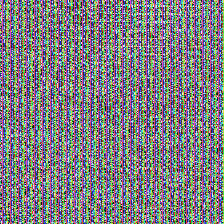

In [39]:
from PIL import Image

gan_image = [x for (x,y),gen_type in zip(train_dataset,train_data.generate_type) if gen_type=='None'][0]
gan_image = gan_image.numpy()
gan_image = gan_image * np.array((0.229, 0.224, 0.225)).reshape((3, 1, 1)) + np.array((0.485, 0.456, 0.406)).reshape((3, 1, 1))

Image.fromarray(gan_image.T,'RGB')

<br></br>

# Modeling

<br>

## Model Define

In [40]:
class BaseModel(nn.Module):
    def __init__(self, num_classes, dropout, activation):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        # self.backbone = models.efficientnet_b7(pretrained=True)
        # self.backbone = models.vit_b_16(pretrained=True)
        # self.backbone = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        # self.backbone = timm.models.swin_base_patch4_window7_224()
        # self.backbone.load_state_dict(torch.load('./pretrained/swin_base_patch4_window7_224.pt'))
        
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(1000)
        self.activation = activation
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.classifier(x)
        return x

<br>

## Train

In [41]:
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: green')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

In [42]:
# https://aimaster.tistory.com/82
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [43]:
import gc
import time
from tqdm import tqdm
from sklearn.metrics import f1_score

def train(model, num_epochs, optimizer, train_loader, val_loader, scheduler, device, mc_path, crosstable):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    # criterion = FocalLoss().to(device)
    
    best_score = 0
    best_model = None
    best_iter  = 0
    
    preds, true_labels = [],[]
    total_s = time.time()
    for epoch in range(1, num_epochs+1):
        gc.collect()
        epoch_s = time.time()
        model.train()
        train_loss = []
        pbar = tqdm(iter(train_loader))
        for imgs, labels in pbar:
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)            
            loss = criterion(output, labels)
            
            preds += output.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            train_score = f1_score(true_labels, preds, average='weighted')
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            pbar.set_description('Train Dataset (score: {:.4f}),{}'.format(train_score,len(pd.unique(preds))))
                    
        mean_val_loss, val_score = validation(model, criterion, val_loader, device, crosstable)
        mean_train_loss = np.mean(train_loss)
       
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_score = val_score
            best_model = model
            torch.save(model.state_dict(), mc_path+'/best_model.pt')
            best_iter=epoch
            is_best=1
        else:
            is_best=0
        
        mark = '*' if is_best==1 else ' '
        epoch_e = time.time()
        epoch_r = epoch_e-epoch_s
        total_r = epoch_e-total_s
        remain_r = (num_epochs-epoch)*epoch_r
        epoch_str = str(epoch).zfill(len(str(num_epochs)))
        progress = '{}[{}/{}], loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, best: {:.4f}({}), elapsed: {:.1f}s, total: {:.1f}s, remaining: {:.1f}s\n'\
            .format(mark,epoch_str,num_epochs,mean_train_loss,mean_val_loss,val_score,best_score,best_iter,epoch_r,total_r,remain_r)
        print(progress)
            
    # 모든 epoch이 끝나면 최종 모델 저장
    torch.save(model.state_dict(), mc_path+'/final_model.pt')
    
    return best_model

In [44]:
def validation(model, criterion, val_loader, device, crosstable):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        pbar = tqdm(iter(val_loader))
        for imgs, labels in pbar:
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            val_score = f1_score(true_labels, preds, average='weighted')
            
            val_loss.append(loss.item())
            pbar.set_description('Valid Dataset (score: {:.4f})'.format(val_score))
        
        mean_val_loss = np.mean(val_loss)
        val_score = f1_score(true_labels, preds, average='weighted')
        
        if crosstable:
            ct = pd.crosstab(
                    le.inverse_transform(true_labels), le.inverse_transform(preds),
                    rownames=['Actual'], colnames=['Prediction'], margins=True,
                )
            display(ct.style.apply(highlight_diag, axis=None))
    return mean_val_loss, val_score

In [45]:
## epoch당 시간
# Train(6,316), Valid(1,038) : 8분

gc.collect()
seed_everything(CFG['SEED'])

model = BaseModel(
    num_classes=len(le.classes_),
    dropout=0.5,
    activation=nn.ReLU(),
)
model.eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG['LEARNING_RATE'], weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(
    model=model,
    num_epochs=CFG['EPOCHS'],
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    device=device,
    mc_path=MC_PATH,
    crosstable=False,
)

Valid Dataset (score: 0.4133): 100%|██████████| 9/9 [00:01<00:00,  4.73it/s]


*[001/128], loss: 2.0928, val_loss: 1.9042, val_score: 0.4133, best: 0.4133(1), elapsed: 28.2s, total: 28.4s, remaining: 3583.3s



Valid Dataset (score: 0.6020): 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


*[002/128], loss: 0.8508, val_loss: 1.2729, val_score: 0.6020, best: 0.6020(2), elapsed: 17.3s, total: 45.8s, remaining: 2174.5s



Valid Dataset (score: 0.7168): 100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


*[003/128], loss: 0.3733, val_loss: 0.9711, val_score: 0.7168, best: 0.7168(3), elapsed: 17.6s, total: 63.6s, remaining: 2204.6s



Valid Dataset (score: 0.7553): 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


*[004/128], loss: 0.2092, val_loss: 0.7974, val_score: 0.7553, best: 0.7553(4), elapsed: 17.8s, total: 81.5s, remaining: 2205.6s



Valid Dataset (score: 0.7550): 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


 [005/128], loss: 0.1396, val_loss: 0.7610, val_score: 0.7550, best: 0.7553(4), elapsed: 17.6s, total: 99.2s, remaining: 2161.1s



Valid Dataset (score: 0.7708): 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


*[006/128], loss: 0.1066, val_loss: 0.7389, val_score: 0.7708, best: 0.7708(6), elapsed: 17.6s, total: 117.0s, remaining: 2152.7s



Valid Dataset (score: 0.7340): 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


 [007/128], loss: 0.0917, val_loss: 0.8815, val_score: 0.7340, best: 0.7708(6), elapsed: 17.7s, total: 134.9s, remaining: 2139.3s



Valid Dataset (score: 0.7582): 100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


 [008/128], loss: 0.0767, val_loss: 0.8026, val_score: 0.7582, best: 0.7708(6), elapsed: 18.0s, total: 153.0s, remaining: 2157.2s



Valid Dataset (score: 0.7914): 100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


*[009/128], loss: 0.0592, val_loss: 0.7316, val_score: 0.7914, best: 0.7914(9), elapsed: 18.1s, total: 171.3s, remaining: 2153.5s



Valid Dataset (score: 0.7756): 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


 [010/128], loss: 0.0456, val_loss: 0.7181, val_score: 0.7756, best: 0.7914(9), elapsed: 17.9s, total: 189.4s, remaining: 2117.9s



Valid Dataset (score: 0.7841): 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


 [011/128], loss: 0.0583, val_loss: 0.7191, val_score: 0.7841, best: 0.7914(9), elapsed: 18.0s, total: 207.5s, remaining: 2105.7s



Valid Dataset (score: 0.8034): 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


*[012/128], loss: 0.0469, val_loss: 0.6759, val_score: 0.8034, best: 0.8034(12), elapsed: 18.2s, total: 225.9s, remaining: 2115.3s



Valid Dataset (score: 0.7891): 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


 [013/128], loss: 0.0547, val_loss: 0.7214, val_score: 0.7891, best: 0.8034(12), elapsed: 18.2s, total: 244.2s, remaining: 2089.4s



Valid Dataset (score: 0.7971): 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


 [014/128], loss: 0.0465, val_loss: 0.8657, val_score: 0.7971, best: 0.8034(12), elapsed: 18.2s, total: 262.6s, remaining: 2079.7s



Valid Dataset (score: 0.7683): 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.
 [015/128], loss: 0.0439, val_loss: 0.8049, val_score: 0.7683, best: 0.8034(12), elapsed: 18.5s, total: 281.3s, remaining: 2089.0s



Valid Dataset (score: 0.8170): 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


*[016/128], loss: 0.0410, val_loss: 0.6107, val_score: 0.8170, best: 0.8170(16), elapsed: 18.5s, total: 299.9s, remaining: 2073.5s



Valid Dataset (score: 0.8150): 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


 [017/128], loss: 0.0219, val_loss: 0.6365, val_score: 0.8150, best: 0.8170(16), elapsed: 18.5s, total: 318.5s, remaining: 2048.6s



Valid Dataset (score: 0.8143): 100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


 [018/128], loss: 0.0237, val_loss: 0.7329, val_score: 0.8143, best: 0.8170(16), elapsed: 18.5s, total: 337.1s, remaining: 2031.1s



Valid Dataset (score: 0.8203): 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


*[019/128], loss: 0.0161, val_loss: 0.6760, val_score: 0.8203, best: 0.8203(19), elapsed: 18.8s, total: 356.1s, remaining: 2052.0s



Valid Dataset (score: 0.8238): 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


*[020/128], loss: 0.0154, val_loss: 0.7292, val_score: 0.8238, best: 0.8238(20), elapsed: 18.8s, total: 375.1s, remaining: 2031.5s



Valid Dataset (score: 0.8098): 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


 [021/128], loss: 0.0172, val_loss: 0.6026, val_score: 0.8098, best: 0.8238(20), elapsed: 18.8s, total: 394.0s, remaining: 2011.2s



Valid Dataset (score: 0.8089): 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


 [022/128], loss: 0.0228, val_loss: 0.6482, val_score: 0.8089, best: 0.8238(20), elapsed: 19.0s, total: 413.2s, remaining: 2012.9s



Valid Dataset (score: 0.8150): 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.
 [023/128], loss: 0.0157, val_loss: 0.6778, val_score: 0.8150, best: 0.8238(20), elapsed: 19.1s, total: 432.4s, remaining: 2005.4s



Valid Dataset (score: 0.8211): 100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


 [024/128], loss: 0.0118, val_loss: 0.6919, val_score: 0.8211, best: 0.8238(20), elapsed: 19.1s, total: 451.7s, remaining: 1991.5s



Valid Dataset (score: 0.8176): 100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


 [025/128], loss: 0.0124, val_loss: 0.6612, val_score: 0.8176, best: 0.8238(20), elapsed: 19.3s, total: 471.2s, remaining: 1988.1s



Valid Dataset (score: 0.8260): 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


*[026/128], loss: 0.0077, val_loss: 0.6881, val_score: 0.8260, best: 0.8260(26), elapsed: 19.5s, total: 490.8s, remaining: 1984.3s



Valid Dataset (score: 0.8245): 100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


 [027/128], loss: 0.0116, val_loss: 0.6237, val_score: 0.8245, best: 0.8260(26), elapsed: 19.5s, total: 510.4s, remaining: 1968.6s



Valid Dataset (score: 0.8248): 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


 [028/128], loss: 0.0070, val_loss: 0.5977, val_score: 0.8248, best: 0.8260(26), elapsed: 19.5s, total: 530.0s, remaining: 1946.2s



Valid Dataset (score: 0.8178): 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.
 [029/128], loss: 0.0114, val_loss: 0.6406, val_score: 0.8178, best: 0.8260(26), elapsed: 19.6s, total: 549.8s, remaining: 1940.8s



Valid Dataset (score: 0.8296): 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


*[030/128], loss: 0.0107, val_loss: 0.6912, val_score: 0.8296, best: 0.8296(30), elapsed: 19.8s, total: 569.7s, remaining: 1935.8s



Valid Dataset (score: 0.8288): 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


 [031/128], loss: 0.0089, val_loss: 0.6692, val_score: 0.8288, best: 0.8296(30), elapsed: 19.8s, total: 589.6s, remaining: 1922.1s



Valid Dataset (score: 0.8278): 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


 [032/128], loss: 0.0079, val_loss: 0.6318, val_score: 0.8278, best: 0.8296(30), elapsed: 19.8s, total: 609.6s, remaining: 1900.8s



Valid Dataset (score: 0.8327): 100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


*[033/128], loss: 0.0066, val_loss: 0.6102, val_score: 0.8327, best: 0.8327(33), elapsed: 20.2s, total: 629.9s, remaining: 1918.1s



Valid Dataset (score: 0.8327): 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


*[034/128], loss: 0.0082, val_loss: 0.6281, val_score: 0.8327, best: 0.8327(34), elapsed: 20.1s, total: 650.2s, remaining: 1890.4s



Valid Dataset (score: 0.8319): 100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


 [035/128], loss: 0.0060, val_loss: 0.7691, val_score: 0.8319, best: 0.8327(34), elapsed: 20.1s, total: 670.5s, remaining: 1871.7s



Valid Dataset (score: 0.8243): 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


Epoch 00036: reducing learning rate of group 0 to 3.1250e-05.
 [036/128], loss: 0.0068, val_loss: 0.6203, val_score: 0.8243, best: 0.8327(34), elapsed: 20.3s, total: 690.9s, remaining: 1864.9s



Valid Dataset (score: 0.8185): 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


 [037/128], loss: 0.0066, val_loss: 0.6668, val_score: 0.8185, best: 0.8327(34), elapsed: 20.4s, total: 711.4s, remaining: 1851.9s



Valid Dataset (score: 0.8226): 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


 [038/128], loss: 0.0052, val_loss: 0.6535, val_score: 0.8226, best: 0.8327(34), elapsed: 20.4s, total: 731.9s, remaining: 1832.0s



Valid Dataset (score: 0.8211): 100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


Epoch 00039: reducing learning rate of group 0 to 1.5625e-05.
 [039/128], loss: 0.0084, val_loss: 0.6119, val_score: 0.8211, best: 0.8327(34), elapsed: 20.6s, total: 752.6s, remaining: 1830.1s



Valid Dataset (score: 0.8224): 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


 [040/128], loss: 0.0056, val_loss: 0.6606, val_score: 0.8224, best: 0.8327(34), elapsed: 20.7s, total: 773.5s, remaining: 1821.3s



Valid Dataset (score: 0.8194): 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


 [041/128], loss: 0.0054, val_loss: 0.7536, val_score: 0.8194, best: 0.8327(34), elapsed: 20.7s, total: 794.3s, remaining: 1802.3s



Valid Dataset (score: 0.8147): 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Epoch 00042: reducing learning rate of group 0 to 7.8125e-06.
 [042/128], loss: 0.0068, val_loss: 0.7200, val_score: 0.8147, best: 0.8327(34), elapsed: 20.8s, total: 815.3s, remaining: 1789.5s



Valid Dataset (score: 0.8236): 100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


 [043/128], loss: 0.0046, val_loss: 0.6326, val_score: 0.8236, best: 0.8327(34), elapsed: 20.9s, total: 836.4s, remaining: 1777.6s



Valid Dataset (score: 0.8197): 100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


 [044/128], loss: 0.0073, val_loss: 0.6726, val_score: 0.8197, best: 0.8327(34), elapsed: 20.9s, total: 857.4s, remaining: 1752.2s



Valid Dataset (score: 0.8260): 100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


Epoch 00045: reducing learning rate of group 0 to 3.9063e-06.
 [045/128], loss: 0.0058, val_loss: 0.6622, val_score: 0.8260, best: 0.8327(34), elapsed: 21.1s, total: 878.6s, remaining: 1748.4s



Valid Dataset (score: 0.8235): 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


 [046/128], loss: 0.0047, val_loss: 0.6529, val_score: 0.8235, best: 0.8327(34), elapsed: 21.1s, total: 899.9s, remaining: 1733.8s



Valid Dataset (score: 0.8225): 100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


 [047/128], loss: 0.0063, val_loss: 0.6761, val_score: 0.8225, best: 0.8327(34), elapsed: 21.2s, total: 921.3s, remaining: 1719.3s



Valid Dataset (score: 0.8324): 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Epoch 00048: reducing learning rate of group 0 to 1.9531e-06.
 [048/128], loss: 0.0058, val_loss: 0.7288, val_score: 0.8324, best: 0.8327(34), elapsed: 21.4s, total: 942.8s, remaining: 1712.4s



Valid Dataset (score: 0.8273): 100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


 [049/128], loss: 0.0063, val_loss: 0.6153, val_score: 0.8273, best: 0.8327(34), elapsed: 21.3s, total: 964.3s, remaining: 1686.4s



Valid Dataset (score: 0.8178): 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


 [050/128], loss: 0.0051, val_loss: 0.7787, val_score: 0.8178, best: 0.8327(34), elapsed: 21.4s, total: 985.9s, remaining: 1673.0s



Valid Dataset (score: 0.8294): 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Epoch 00051: reducing learning rate of group 0 to 9.7656e-07.
 [051/128], loss: 0.0045, val_loss: 0.6662, val_score: 0.8294, best: 0.8327(34), elapsed: 21.5s, total: 1007.6s, remaining: 1659.3s



Valid Dataset (score: 0.8233): 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


 [052/128], loss: 0.0049, val_loss: 0.6892, val_score: 0.8233, best: 0.8327(34), elapsed: 21.7s, total: 1029.5s, remaining: 1650.9s



Valid Dataset (score: 0.8213): 100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


 [053/128], loss: 0.0054, val_loss: 0.8061, val_score: 0.8213, best: 0.8327(34), elapsed: 21.8s, total: 1051.5s, remaining: 1638.7s



Valid Dataset (score: 0.8314): 100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


Epoch 00054: reducing learning rate of group 0 to 4.8828e-07.
 [054/128], loss: 0.0053, val_loss: 0.6390, val_score: 0.8314, best: 0.8327(34), elapsed: 21.9s, total: 1073.6s, remaining: 1622.0s



Valid Dataset (score: 0.8249): 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


 [055/128], loss: 0.0057, val_loss: 0.6955, val_score: 0.8249, best: 0.8327(34), elapsed: 21.8s, total: 1095.6s, remaining: 1593.2s



Valid Dataset (score: 0.8235): 100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


 [056/128], loss: 0.0070, val_loss: 0.6464, val_score: 0.8235, best: 0.8327(34), elapsed: 22.1s, total: 1117.9s, remaining: 1594.3s



Valid Dataset (score: 0.8260): 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


Epoch 00057: reducing learning rate of group 0 to 2.4414e-07.
 [057/128], loss: 0.0047, val_loss: 0.6119, val_score: 0.8260, best: 0.8327(34), elapsed: 22.1s, total: 1140.2s, remaining: 1571.7s



Valid Dataset (score: 0.8300): 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


 [058/128], loss: 0.0055, val_loss: 0.6076, val_score: 0.8300, best: 0.8327(34), elapsed: 22.3s, total: 1162.7s, remaining: 1564.5s



Valid Dataset (score: 0.8237): 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


 [059/128], loss: 0.0067, val_loss: 0.7042, val_score: 0.8237, best: 0.8327(34), elapsed: 22.4s, total: 1185.2s, remaining: 1544.1s



Valid Dataset (score: 0.8223): 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


Epoch 00060: reducing learning rate of group 0 to 1.2207e-07.
 [060/128], loss: 0.0045, val_loss: 0.6925, val_score: 0.8223, best: 0.8327(34), elapsed: 22.5s, total: 1207.8s, remaining: 1528.2s



Train Dataset (score: 0.9814),19:  16%|█▌        | 4/25 [00:04<00:22,  1.05s/it]


KeyboardInterrupt: ignored

<br></br>

# Inference

<br>

## Test Data Load

In [46]:
def inference(model, loader, device):
    model.eval()
    trues = []
    preds = []
    with torch.no_grad():
        for imgs,labels in tqdm(iter(loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)

            trues += labels.numpy().tolist()
            preds += pred.argmax(1).detach().cpu().numpy().tolist()

    return trues, preds

In [47]:
def inference_test(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()

    # for i,label in enumerate(le.classes_):
    #   print(i,label)
    
    # preds = le.inverse_transform(preds)
    
    return preds

In [48]:
def label_decoder(label):
    new_label = [
        '가구수정' if l==0 else
        '걸레받이수정' if l==1 else
        '곰팡이' if l==2 else
        '꼬임' if l==3 else
        '녹오염' if l==4 else
        '들뜸' if l==5 else
        '면불량' if l==6 else
        '몰딩수정' if l==7 else
        '반점' if l==8 else
        '석고수정' if l==9 else
        '오염' if l==10 else
        '오타공' if l==11 else
        '울음' if l==12 else
        '이음부불량' if l==13 else
        '창틀,문틀수정' if l==14 else
        '터짐' if l==15 else
        '틈새과다' if l==16 else
        '피스' if l==17 else
        '훼손' if l==18 else
        'NaN' for l in label
    ]
    return new_label

In [49]:
infer_model = BaseModel(
    num_classes=len(le.classes_),
    dropout=0.5,
    activation=nn.ReLU(),
)
infer_model.to(device)
infer_model.load_state_dict(torch.load(MC_PATH+'/best_model_230428_2.pt'))

<All keys matched successfully>

In [50]:
tr_trues, tr_preds = inference(infer_model, train_loader, device)
va_trues, va_preds = inference(infer_model, val_loader  , device)

100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


In [51]:
tr_score = f1_score(tr_trues, tr_preds, average='weighted')
va_score = f1_score(va_trues, va_preds, average='weighted')
print("Train Score: {:.4f}, Validation Score: {:.4f}".format(tr_score,va_score))

pd.crosstab(
    label_decoder(va_trues), label_decoder(va_preds),
    rownames=['Actual'], colnames=['Prediction'], margins=True,
)

Train Score: 0.9997, Validation Score: 0.8327


Prediction,걸레받이수정,곰팡이,꼬임,녹오염,들뜸,면불량,몰딩수정,반점,석고수정,오염,오타공,울음,이음부불량,"창틀,문틀수정",터짐,피스,훼손,All
Actual,,,,,,,,,,,,,,,,,,
가구수정,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4
걸레받이수정,83,2,0,0,0,1,0,0,0,3,0,0,0,0,0,0,3,92
곰팡이,1,35,0,0,0,0,0,0,1,2,0,1,0,0,0,0,3,43
꼬임,0,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,4,63
녹오염,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,1,0,4
들뜸,0,0,0,0,11,0,2,0,0,1,0,0,0,0,0,0,2,16
면불량,0,1,0,0,1,16,0,0,0,4,1,0,0,0,1,0,6,30
몰딩수정,1,0,0,0,0,1,32,0,2,0,0,0,0,0,0,0,3,39
반점,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [60]:
test = pd.read_csv(REF_PATH+'/data/test.csv')
test.img_path = test.img_path.apply(lambda x: x.replace('./','./data/'))

test_dataset = CustomDataset(test['img_path'].values, None, transform, n_jobs=-1, desc='Test Data Load')
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

preds = inference_test(infer_model, test_loader, device)
preds = label_decoder(preds)

100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


In [61]:
pd.Series(preds).value_counts(), len(preds)

(훼손         373
 오염         230
 꼬임          28
 면불량         28
 터짐          25
 오타공         21
 몰딩수정        19
 석고수정        11
 곰팡이         10
 걸레받이수정       9
 피스           8
 창틀,문틀수정      7
 이음부불량        5
 들뜸           5
 녹오염          5
 울음           4
 가구수정         4
 dtype: int64,
 792)

In [63]:
# 저장 후, 해당파일 열어서 UTF-8 선택필요
submit = pd.read_csv('./data/sample_submission.csv')
submit['label'] = preds
submit.to_csv('./out/baseline_submit_14.csv', index=False, encoding='utf-8')

<br>

## Submission

In [ ]:
# 저장 후, 해당파일 열어서 UTF-8 선택필요
submit = pd.read_csv('./data/sample_submission.csv')
submit['label'] = preds
submit.to_csv('./out/baseline_submit_10.csv', index=False, encoding='utf-8')

In [ ]:
submit_1['label'].nunique(),submit_2['label'].nunique()

In [ ]:
submit_1 = pd.read_csv('./out/baseline_submit_3.csv')
submit_2 = pd.read_csv('./out/baseline_submit_9.csv')

f1=f1_score(submit_1['label'],submit_2['label'],average='weighted')
print('f1_score:',f1)

ct = pd.crosstab(submit_1['label'],submit_2['label'],margins=True)
ct.style.apply(highlight_diag, axis=None)

In [ ]:
list(set(pd.unique(le.inverse_transform(val_data.label)))-set(submit.label.unique()))

<br></br>